In [11]:
# install libs
!pip install matplotlib tqdm keras tensorflow-macos pandas scikit-learn

In [12]:
import os
os.listdir("images")
print(len(os.listdir("images")))

9367


In [13]:
!which pip

/Users/tiago.cabo/Documents/Kitchenware_classification/venv/bin/pip


In [14]:
import sys
sys.executable

'/Users/tiago.cabo/Documents/Kitchenware_classification/venv/bin/python'

In [15]:
import matplotlib.pyplot as plt
import matplotlib.image as mpimg

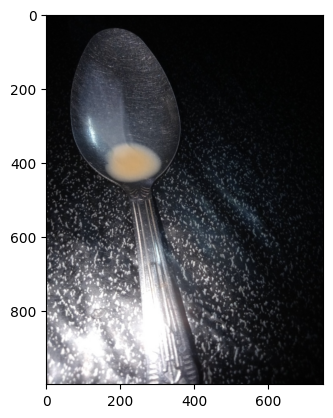

In [16]:
import random

# select one random image
image = random.sample(os.listdir("images"),1)[0]
img = mpimg.imread(f'images/{image}')
imgplot = plt.imshow(img)
plt.show()

# Resize images

Looking to the pictures, they have different sizes, since the CNN only accepts same size images, we need to resized them. 

In [17]:
from PIL import Image

In [18]:
input_shape = (150,150,1)

In [19]:
input_shape[0]

150

In [20]:
image_nr = random.sample(os.listdir("images"),1)[0]
image = Image.open(f"images/{image_nr}")
resize_images = image.resize((input_shape[0],input_shape[0]))

In [21]:
type(resize_images)

PIL.Image.Image

In [22]:
import numpy as np

np_image= np.array(resize_images)

In [23]:
# Since image is colored, the shape is (x,x,3)
# From now on I will assume that color is not relevant in the exercise, so I will use just on color channel
np_image.shape

(150, 150, 3)

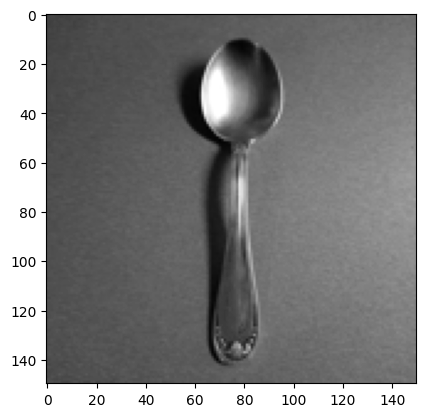

In [24]:
# convert to one channel
plt.imshow(np_image[:,:,1], cmap="gray")

# Create train/test dataset

In [25]:
import pandas as pd

In [26]:
train_index_data = pd.read_csv("train.csv")

In [27]:
from sklearn.model_selection import train_test_split

In [28]:
from sklearn.preprocessing import LabelEncoder

In [29]:
encoder = LabelEncoder()

In [30]:
encoder.fit(train_index_data["label"])

LabelEncoder()

In [31]:
train_index_data["label"]=  encoder.transform(train_index_data["label"])

In [32]:
index_train, index_test, y_train, y_test = train_test_split(train_index_data["Id"], train_index_data["label"], test_size=0.33, random_state=42)

In [33]:
y_test

4963    4
4943    3
4345    5
230     5
1044    0
       ..
3666    1
1890    4
3898    1
2677    4
1592    5
Name: label, Length: 1835, dtype: int64

In [34]:
# Let's prepare dataset with the following shape (9367, 224,224,1)
from tqdm import tqdm

def prepare_numpy_dataset(images_index, nr_channels = 3):
    data = []
    for index in tqdm(images_index):
        image = Image.open(f"images/{str(index).zfill(4)}.jpg")
        # image resize
        image = image.resize((input_shape[0],input_shape[0]))
        data.append(np.array(image))
    data = np.array(data)
    # just 1 channel
    data = data[:, :,:, :nr_channels]
    return data

In [35]:
X_train = prepare_numpy_dataset(images_index = index_train)

100%|██████████████████████████████████████| 3724/3724 [00:34<00:00, 106.75it/s]


In [37]:
X_test = prepare_numpy_dataset(images_index = index_test)

100%|██████████████████████████████████████| 1835/1835 [00:17<00:00, 105.21it/s]


In [36]:
X_train.shape

(3724, 150, 150, 3)

In [39]:
# add missing color channel
X_train  = X_train.reshape(X_train.shape[0], input_shape[0], input_shape[0], 3)
X_test  = X_test.reshape(X_test.shape[0], input_shape[0], input_shape[0], 3)

In [40]:
X_train.shape

(3724, 150, 150, 3)

In [41]:
# Let's normalize data by dividing by 255 
X_train = X_train/255
X_test = X_test/255

In [ ]:
# Importing the required Keras modules containing model and layers
from keras.models import Sequential
from keras.layers import Dense, Conv2D, Dropout, Flatten, MaxPooling2D, BatchNormalization
from keras.callbacks import EarlyStopping
import tensorflow as tf

In [75]:
# Creating a Sequential Model and adding the layers
model = Sequential()
model.add(Conv2D(64, kernel_size=(3,3), input_shape=input_shape))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten()) # Flattening the 2D arrays for fully connected layers
model.add(Dense(128, activation=tf.nn.relu))
# drop 20% of the inputs
model.add(Dropout(0.25))
model.add(BatchNormalization())
model.add(Dense(6,activation=tf.nn.softmax))

In [76]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 148, 148, 64)      640       
                                                                 
 batch_normalization_4 (Batc  (None, 148, 148, 64)     256       
 hNormalization)                                                 
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 74, 74, 64)       0         
 2D)                                                             
                                                                 
 flatten_2 (Flatten)         (None, 350464)            0         
                                                                 
 dense_6 (Dense)             (None, 128)               44859520  
                                                                 
 dropout_2 (Dropout)         (None, 128)              

# Pretrained Model

In [77]:
# number of categories
len(set(y_train))

6

In [1]:
from keras.applications.xception import Xception
import keras

In [5]:
import ssl

ssl._create_default_https_context = ssl._create_unverified_context

pretrained_model = Xception(
    include_top=False,
    weights='imagenet',
    input_shape=(150,150,3))

pretrained_model.treinable = False

inputs = keras.Input(shape=(150,150,3))
base = pretrained_model(inputs, training=False)


In [ ]:
vectors = keras.layers.GlobalAveragePooling2D()(base)
outputs = keras.layers.Dense(6)(vectors)
pretrained_model = keras.Model(inputs,outputs)

pretrained_model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

import datetime
log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S") + '_Xception_v0'
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

pretrained_model.fit(x=X_train,
          y=y_train,
          epochs=10,
          batch_size=200,
          validation_data=(X_test, y_test),
          callbacks=[tensorboard_callback, EarlyStopping(monitor='loss', patience=3)])

Epoch 1/10
19/19 [==============================] - 206s 10s/step - loss: 5.6169 - accuracy: 0.1442 - val_loss: 5.1493 - val_accuracy: 0.1351
Epoch 2/10
 3/19 [===>..........................] - ETA: 2:38 - loss: 5.1823 - accuracy: 0.1333

In [78]:
model.compile(optimizer='adam',
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])

In [79]:
import datetime
log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S") + '_CNN_v0'
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)

In [80]:
model.fit(x=X_train,
          y=y_train,
          epochs=10,
          batch_size=200,
          validation_data=(X_test, y_test),
          callbacks=[tensorboard_callback, EarlyStopping(monitor='loss', patience=3)])

Epoch 1/10
19/19 [==============================] - 42s 2s/step - loss: 2.1698 - accuracy: 0.3013 - val_loss: 1.7332 - val_accuracy: 0.3150
Epoch 2/10
19/19 [==============================] - 36s 2s/step - loss: 1.6947 - accuracy: 0.3784 - val_loss: 1.7836 - val_accuracy: 0.2431
Epoch 3/10
19/19 [==============================] - 36s 2s/step - loss: 1.4298 - accuracy: 0.4662 - val_loss: 1.7603 - val_accuracy: 0.3264
Epoch 4/10
19/19 [==============================] - 35s 2s/step - loss: 1.2320 - accuracy: 0.5513 - val_loss: 1.7795 - val_accuracy: 0.2147


# Generate test results

In [81]:
# Load test data
test_data = pd.read_csv("test.csv")

In [82]:
test_data.Id

0        678
1       3962
2       9271
3       5133
4       8842
        ... 
3803    7626
3804    2052
3805    8827
3806    2299
3807    2212
Name: Id, Length: 3808, dtype: int64

In [83]:
test_images = prepare_numpy_dataset(images_index = test_data.Id)

100%|████████████████████████████████████████| 3808/3808 [00:36<00:00, 103.67it/s]


In [84]:
predictions = model.predict(test_images)

119/119 [==============================] - 5s 44ms/step


In [85]:
def generate_predictions(raw_predictions):
    for row, pred in tqdm(enumerate(predictions)):
        index = np.argmax(pred)
        test_data.loc[row,"label"] = encoder.inverse_transform([index])[0]

In [86]:
generate_predictions(raw_predictions=predictions)

3808it [00:00, 14049.85it/s]


In [87]:
test_data.Id = test_data.Id.apply(lambda x:str(x).zfill(4))

In [88]:
test_data

Id  label
0     0678  knife
1     3962  plate
2     9271  plate
3     5133  plate
4     8842  plate
...    ...    ...
3803  7626  plate
3804  2052  knife
3805  8827  plate
3806  2299  plate
3807  2212  knife

[3808 rows x 2 columns]

In [89]:
test_data.to_csv("baseline_2.csv", index=False)

# Viz layers

In [90]:
# to capture the weights we do 
conv1_filters, conv1_biases = model.layers[0].get_weights()

In [91]:
# lets normalize filters 
# normalize filter values to 0-1 so we can visualize them
f_min, f_max = conv1_filters.min(), conv1_filters.max()
conv1_filters = (conv1_filters - f_min) / (f_max - f_min)

In [92]:
conv1_filters.shape

(3, 3, 1, 64)

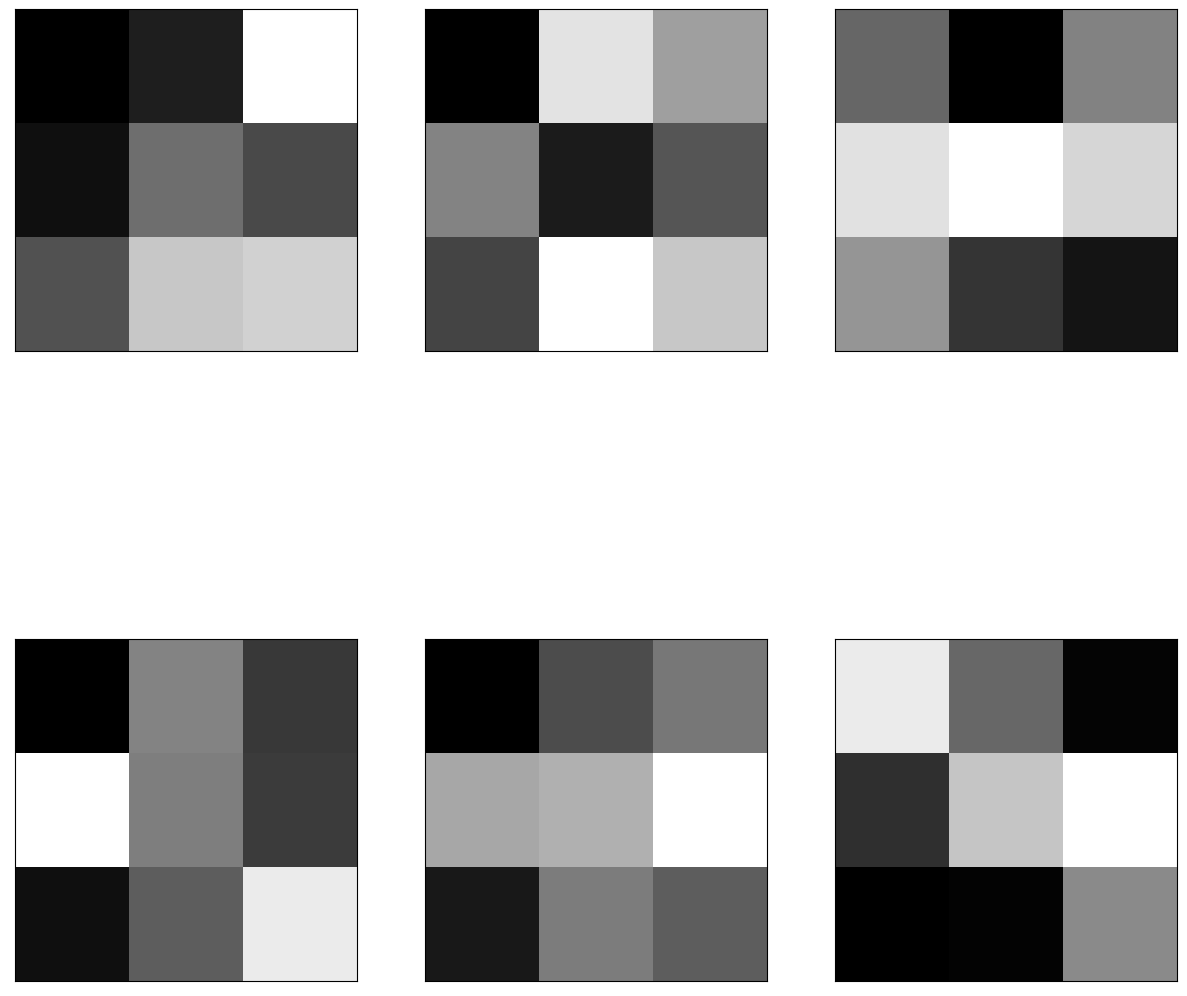

In [93]:
import matplotlib.pyplot as plt 
# plot first 6 filters
n_filters, ix = 6, 1
fig, ax = plt.subplots(2, 3, figsize=(15,15))
axs = ax.flat
for i in range(n_filters):
    # get the filter
    f = conv1_filters[:, :, :, i]
    # plot each channel separately
    # specify subplot and turn of axis
    
    axs[i].set_xticks([])
    axs[i].set_yticks([])
    # plot filter channel in grayscale
    axs[i].imshow(f, cmap='gray')
    ix += 1
# show the figure
plt.show()

# Viz predict layers importance

In [94]:
# summarize feature map shapes
for i in range(len(model.layers)):
	layer = model.layers[i]
	# check for convolutional layer
	if 'conv' not in layer.name:
		continue
	# summarize output shape
	print(i, layer.name, layer.output.shape)

0 conv2d_4 (None, 148, 148, 64)


In [95]:
# Build model just with the first layer
from keras.models import Model
ixs = [0]
outputs = [model.layers[i+1].output for i in ixs]
model = Model(inputs=model.inputs, outputs=outputs)
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4_input (InputLayer)  [(None, 150, 150, 1)]    0         
                                                                 
 conv2d_4 (Conv2D)           (None, 148, 148, 64)      640       
                                                                 
 batch_normalization_4 (Batc  (None, 148, 148, 64)     256       
 hNormalization)                                                 
                                                                 
Total params: 896
Trainable params: 768
Non-trainable params: 128
_________________________________________________________________


In [96]:
test_images.shape

(3808, 150, 150)

In [102]:
# get feature map for first hidden layer
feature_maps = model.predict(test_images[0].reshape((1,150,150,1)))

1/1 [==============================] - 0s 15ms/step


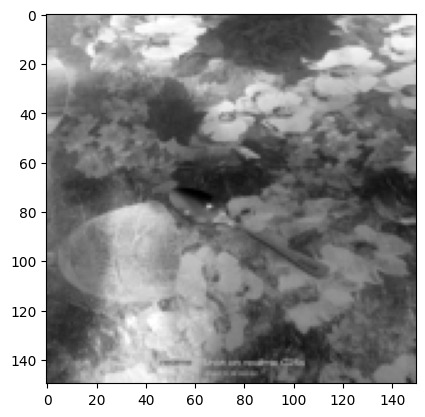

In [110]:
plt.imshow(test_images[0], cmap="gray")

In [103]:
feature_maps.shape

(1, 148, 148, 64)

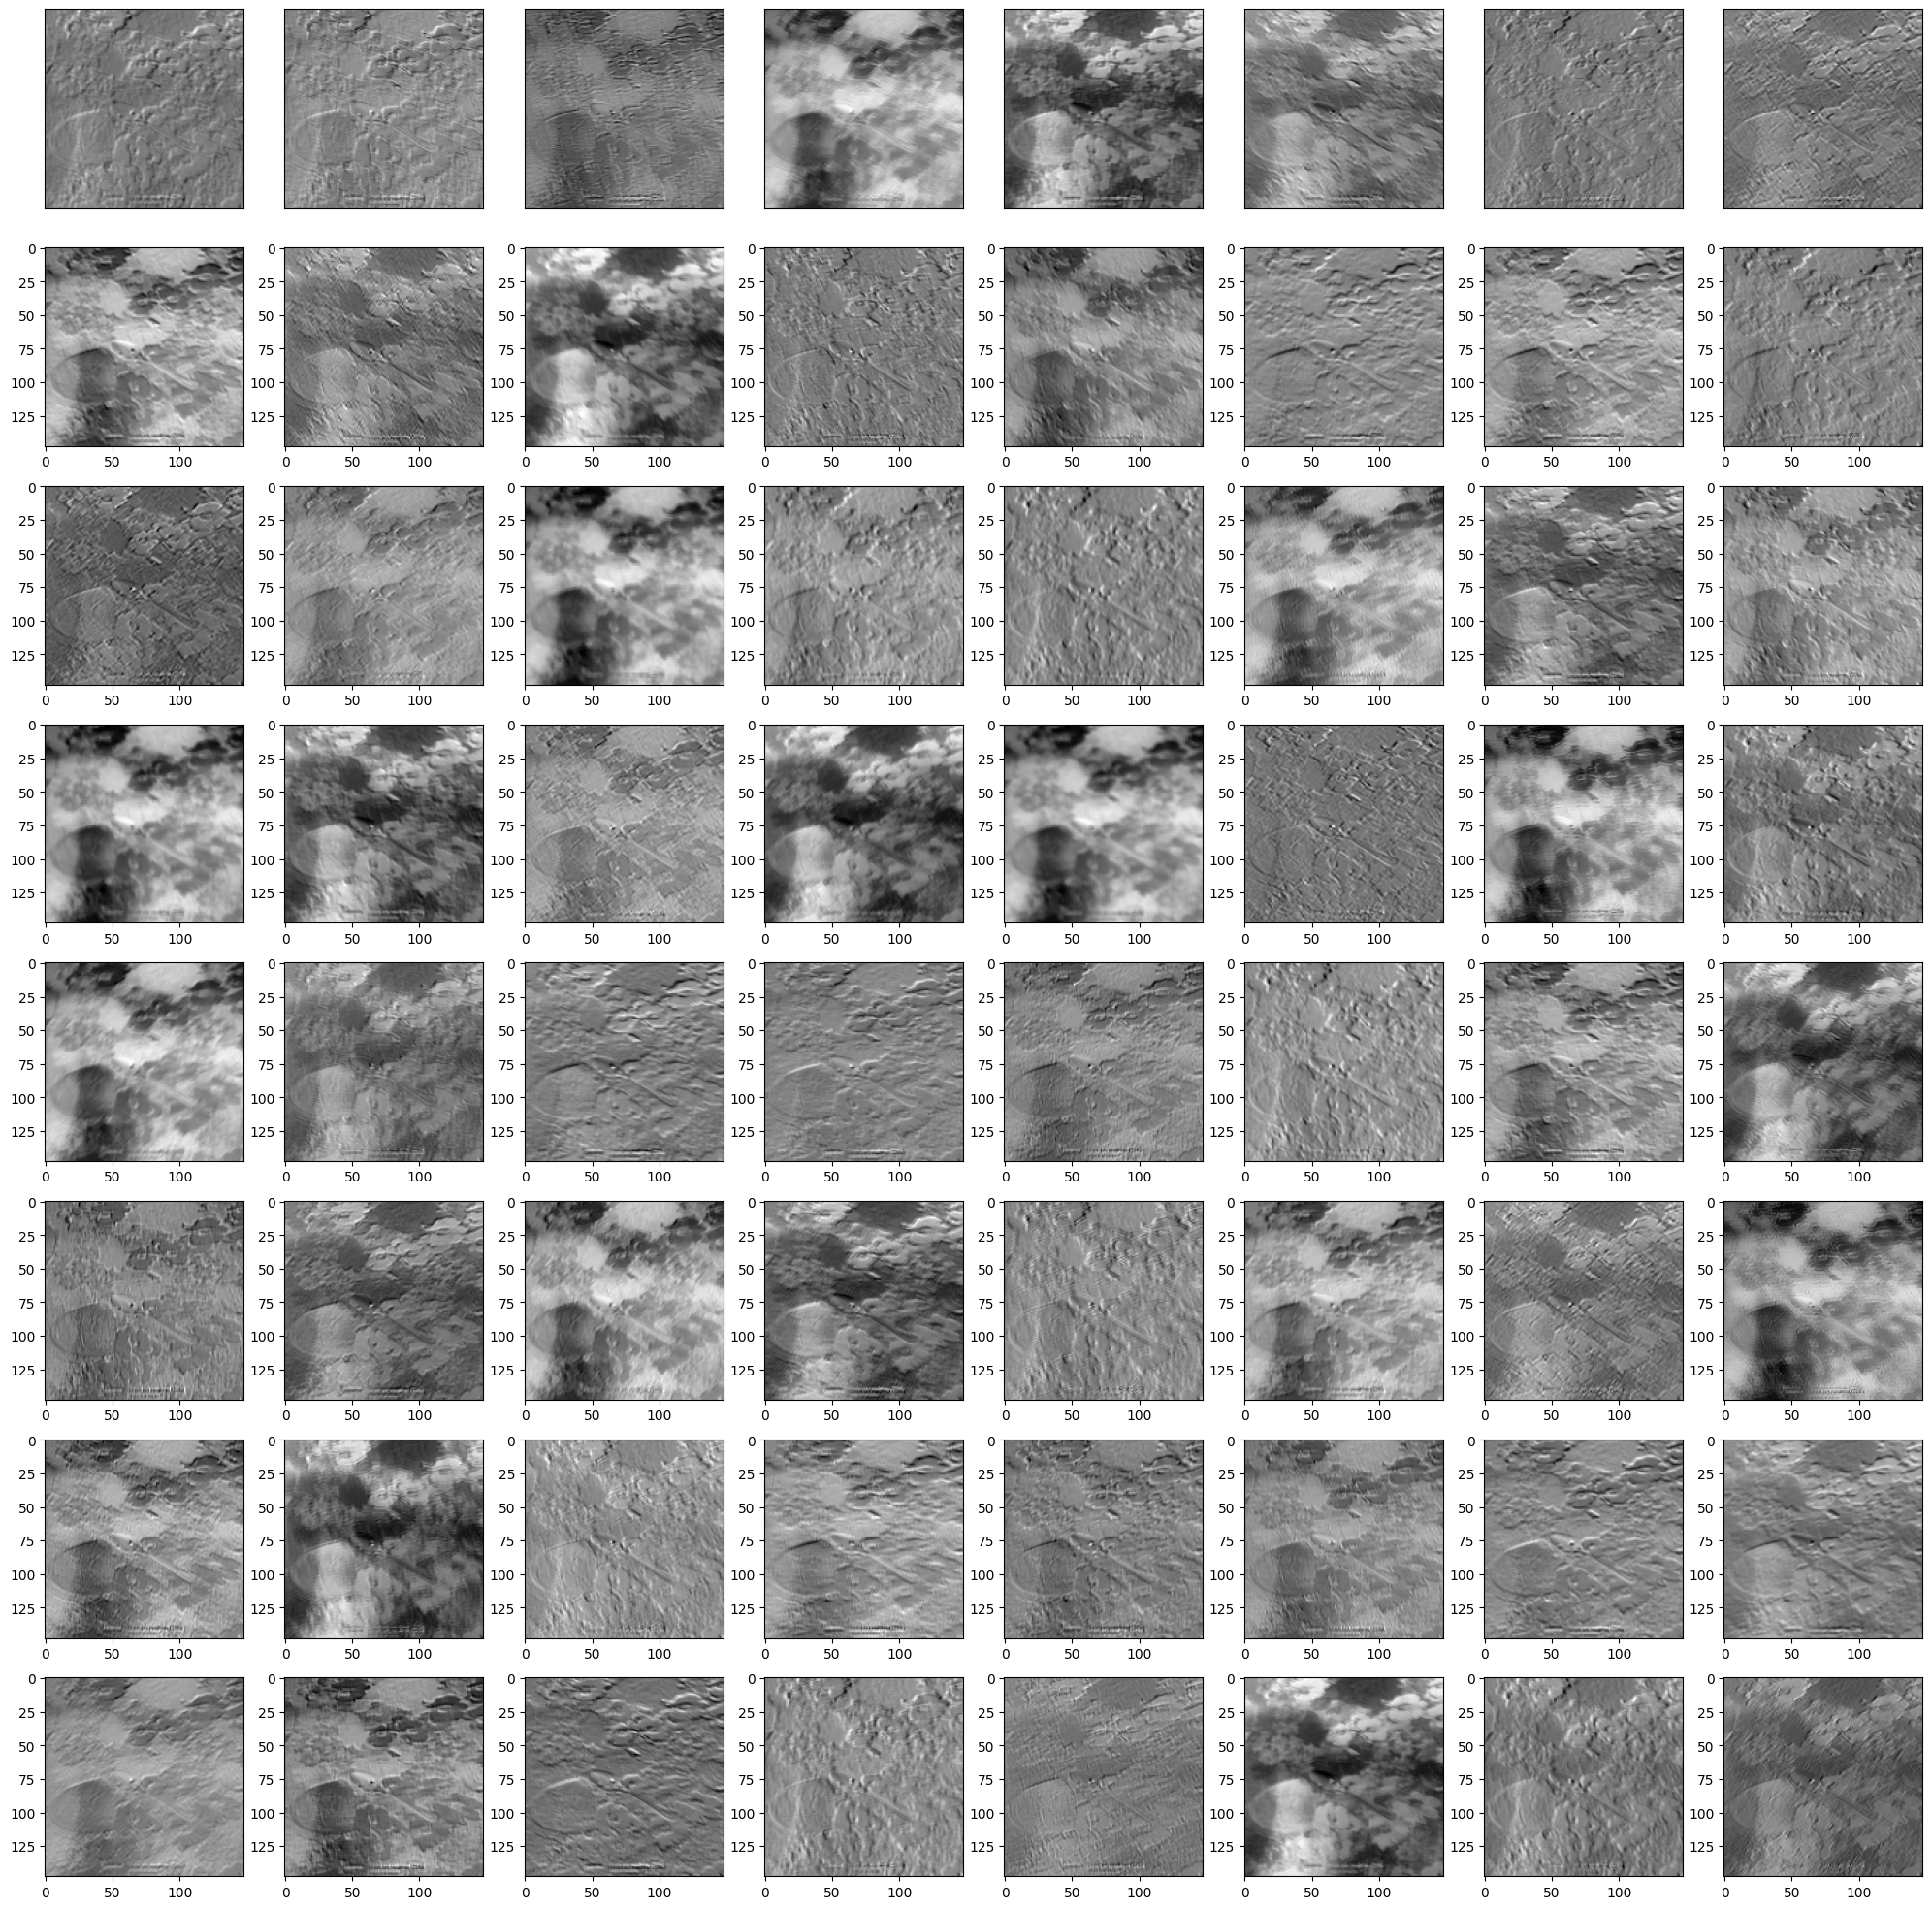

In [104]:
import matplotlib.pyplot as plt
# plot all 64 maps in an 8x8 squares
square = 8
ix = 0
fig, ax = plt.subplots(8,8, figsize=(25,25))
axs = ax.flat
for _ in range(square):
	for _ in range(square):
		# specify subplot and turn of axis
		axs[_].set_xticks([])
		axs[_].set_yticks([])
		# plot filter channel in grayscale
		axs[ix].imshow(feature_maps[0, :, :, ix], cmap='gray')
		ix += 1
# show the figure
plt.show()